In [37]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from scipy.stats import chi2
%matplotlib notebook

<IPython.core.display.Javascript object>


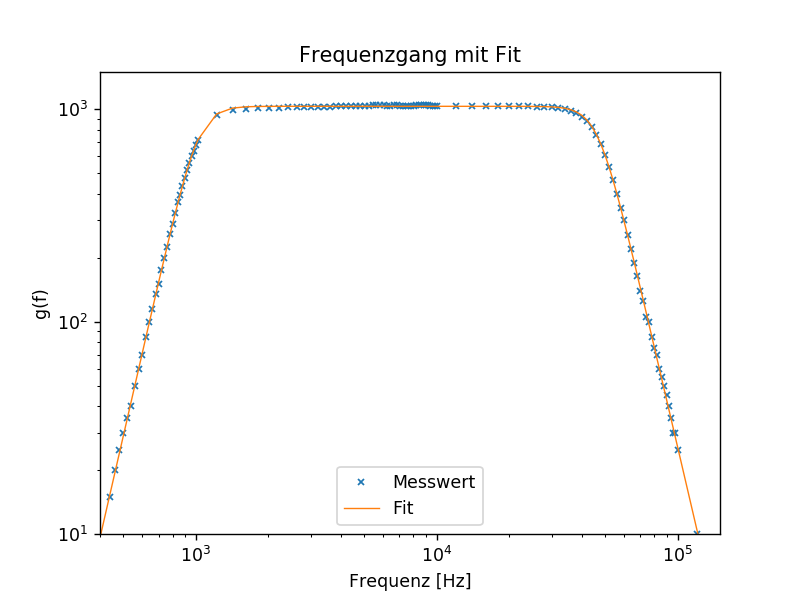

In [44]:
f, U_aus =np.loadtxt(r'C:\Users\Quirinus\Dropbox\Universe\Praktikum\PAP 2.2\243 - Thermisches Rauschen\Daten/Daten_thermischeRauschen.txt', skiprows=1, usecols=(0,1), unpack=True)

D=1e-3
U_ein=0.2
g=U_aus/(U_ein*D)

plt.loglog(f[17:-43],g[17:-43], linestyle='None', marker='x', markersize=3, label='Messwert')
plt.axis([4E2, 1.5e5, 10, 1.5E3])
plt.xlabel('Frequenz [Hz]')
plt.ylabel('g(f)')
plt.title('Frequenzgang')

def fit_func(f,V,W1,W2,n1,n2):
    return V/(np.sqrt(1+1/(f/W1)**(2*n1))*np.sqrt(1+(f/W2)**(2*n2)))

p0= [1000 , 1000 , 50000 , 5 , 5]
popt, pcov = curve_fit(fit_func, f[17:-43], g[17:-43] , p0, 0.02*g[17:-43])
perr = np.sqrt(np.diag(pcov))
plt.loglog(f, fit_func(f, *popt), linewidth=0.8, label='Fit')
plt.axis([4E2, 1.5e5, 10, 1.5E3])
plt.xlabel('Frequenz [Hz]')
plt.ylabel('g(f)')
plt.title('Frequenzgang mit Fit')
plt.legend(loc='best')
plt.savefig(r'C:\Users\Quirinus\Dropbox\Universe\Praktikum\PAP 2.2\243 - Thermisches Rauschen\Diagramme\Frequnzgang.pdf' ,format='pdf')

In [46]:
def fit_func_square (f, V, W1, W2, n1, n2):
    return fit_func(f, V, W1, W2, n1, n2)**2
popt1=popt+perr
popt2=popt-perr
B=integrate.quad(fit_func_square, f[10], f[-43], args=tuple(popt))
Berr1=integrate.quad(fit_func_square, f[10], f[-43], args=tuple((popt1)))
Berr2=integrate.quad(fit_func_square, f[10], f[-43], args=tuple((popt1)))
err1 = abs(Berr1[0]-B[0])
err2 = abs(Berr2[0]-B[0])
err =max(err1, err2)
print('Das Integral betraegt: %.4e +- %.4e' %(round(B[0], 4), round(err, 4)))

Das Integral betraegt: 4.9858e+10 +- 3.3626e+08


In [47]:
R=np.array([30e3, 25e3, 20e3, 15e3, 10e3, 5e3])
U_aus=np.array([5.1223, 4.7013, 4.245, 3.7326, 3.1496, 2.4355])
err_U_aus=np.array([0.018, 0.016, 0.0168, 0.0157, 0.0129, 0.0121])
U_V=1.3812
err_U_V=0.00709
D=U_aus**2-U_V**2
err_D=np.sqrt((2*U_aus*err_U_aus)**2+(2*U_V*err_U_V))

plt.errorbar(R, D, yerr=err_D, fmt='x')

def linear(x, c):
    c*x

chisquare=np.sum(((linear(R,*popt)-D)**2/err_D**2))

dof=5

chisquare_red=chisquare/dof

prob=round(1-chi2.cdf(chisquare,dof),2)*100
plt.xlabel('Widerstand [Ohm]')
plt.ylabel('Reduzierte Rauschspannung [V²m]')
plt.title('Rauschspannung in Abhängigkeit vom Widerstand')
plt.legend()
# plt.savefig(r'G:\Users\Thorben\Uni\GitHub\Universe\Praktikum\PAP 2.2\243 - Thermisches Rauschen\Diagramme\Rauschspannung.pdf' ,format='pdf')
print("Wahrscheinlichkeit="+str(prob)+"%")
print(chisquare)
print(chisquare_red)

<IPython.core.display.Javascript object>

TypeError: linear() takes 2 positional arguments but 6 were given